## Import Required Libraries


In [ ]:
# %pip install torch torchvision --upgrade --force-reinstall

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
from torchsummary import summary
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

from google.colab import files
import numpy as np
import os

## Defining constants

In [ ]:
CHANNELS = 3  # RGB images
IMG_HEIGHT = 32  # height of the image
IMG_WIDTH = 32  # width of the image
INPUT_SIZE = CHANNELS * IMG_HEIGHT * IMG_WIDTH
CINIC_STD = [0.24205776, 0.23828046, 0.25874835]
CINIC_MEAN = [0.47889522, 0.47227842, 0.43047404]

## Defining Hyperparameters


In [ ]:
train_subset_fraction = 1.0   # Using part of the training dataset to speed up experiments
batch_size = 128  # Number of images processed together in one forward/backward pass
learning_rate = 0.001  # Step size for updating weights during optimization
label_smoothing = 0.1 # Label smoothing for better generalization
weighted_decay = 1e-4  # Regularization term to prevent overfitting
num_epochs = 50  # Number of times the model will see the entire training set
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Image Transformations


Since CINIC-10 has 3 channels (RGB), we should give 3 mean and 3 std values.

The means and standard deviations of the (r,g,b) channels was calculated to be:

`cinic_mean_RGB = [0.47889522, 0.47227842, 0.43047404]`

`cinic_std_RGB = [0.24205776, 0.23828046, 0.25874835]`

This centers and scales each color channel individually resulting in speeding up training and improves convergence.


In [ ]:
# Defining tranformation for the training and testing data
train_transform = transforms.Compose(
    [
        transforms.RandomHorizontalFlip(),  # randomly flip image horizontally
        transforms.RandomRotation(10),  # rotate by +/- 10 degrees
        transforms.ToTensor(),  # convert images to PyTorch tensors
        transforms.Normalize(
            mean=CINIC_MEAN, std=CINIC_STD
        ),  # normalize values between -1 and 1
    ]
)

transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize(mean=CINIC_MEAN, std=CINIC_STD),
    ]
)

## Data Collection


### Download dataset directly from kaggle

In [ ]:
files.upload()

! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

! kaggle datasets download -d mengcius/cinic10 --force
! unzip cinic10.zip -d /content/cinic-10

mkdir: cannot create directory ‘/root/.kaggle’: File exists
Dataset URL: https://www.kaggle.com/datasets/mengcius/cinic10
License(s): unknown
 98% 738M/754M [00:02<00:00, 240MB/s]
100% 754M/754M [00:04<00:00, 181MB/s]
Archive:  cinic10.zip
replace /content/cinic-10/README.md? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

### Load datasets

In [ ]:
# Loading the CINIC-10 dataset
root_dir_path = "/content/cinic-10"

trainset = datasets.ImageFolder(root=f"{root_dir_path}/train", transform=train_transform)
testset = datasets.ImageFolder(root=f"{root_dir_path}/test", transform=transform)
validset = datasets.ImageFolder(root=f"{root_dir_path}/valid", transform=transform)

num_train_subset = int(len(trainset) * train_subset_fraction)
train_subset, _ = torch.utils.data.random_split(
    trainset, [num_train_subset, len(trainset) - num_train_subset]
)

## Verification of loaded datasets

In [ ]:
# Count of images in each class
def count_images_in_classes(dataset_path):
    print(f"Checking directory: {dataset_path}")
    class_counts = {}
    if os.path.exists(dataset_path):
        for class_name in os.listdir(dataset_path):
            class_dir = os.path.join(dataset_path, class_name)
            if os.path.isdir(class_dir):
                image_count = len([name for name in os.listdir(class_dir) if os.path.isfile(os.path.join(class_dir, name))])
                class_counts[class_name] = image_count
        return class_counts
    else:
        print(f"Directory not found: {dataset_path}")
        return None

train_path = os.path.join(root_dir_path, 'train')
test_path = os.path.join(root_dir_path, 'test')
valid_path = os.path.join(root_dir_path, 'valid')

print("Training dataset structure and image counts:")
train_class_counts = count_images_in_classes(train_path)
if train_class_counts:
    for class_name, count in train_class_counts.items():
        print(f"  {class_name}: {count} images")

print("\nTesting dataset structure and image counts:")
test_class_counts = count_images_in_classes(test_path)
if test_class_counts:
    for class_name, count in test_class_counts.items():
        print(f"  {class_name}: {count} images")

print("\nValidation dataset structure and image counts:")
test_class_counts = count_images_in_classes(valid_path)
if test_class_counts:
    for class_name, count in test_class_counts.items():
        print(f"  {class_name}: {count} images")

Training dataset structure and image counts:
Checking directory: /content/cinic-10/train
  ship: 9000 images
  bird: 9000 images
  airplane: 9000 images
  automobile: 9000 images
  cat: 9000 images
  frog: 9000 images
  dog: 9000 images
  horse: 9000 images
  deer: 9000 images
  truck: 9000 images

Testing dataset structure and image counts:
Checking directory: /content/cinic-10/test
  ship: 9000 images
  bird: 9000 images
  airplane: 9000 images
  automobile: 9000 images
  cat: 9000 images
  frog: 9000 images
  dog: 9000 images
  horse: 9000 images
  deer: 9000 images
  truck: 9000 images

Validation dataset structure and image counts:
Checking directory: /content/cinic-10/valid
  ship: 9000 images
  bird: 9000 images
  airplane: 9000 images
  automobile: 9000 images
  cat: 9000 images
  frog: 9000 images
  dog: 9000 images
  horse: 9000 images
  deer: 9000 images
  truck: 9000 images


### Data Loaders Creation

In [ ]:
# Creating data loaders for training, testing, and validation datasets
trainloader = data.DataLoader(
    train_subset,
    batch_size=batch_size,
    shuffle=True,
)
testloader = data.DataLoader(
    testset,
    batch_size=batch_size,
    shuffle=False,
)
valloader = data.DataLoader(
    validset,
    batch_size=batch_size,
    shuffle=False,
)

## Data Labeling


In [ ]:
# Checking the number of images in training and testing datasets
print(f"Number of training images: {len(trainset)}")
print(f"Number of testing images: {len(testset)}")
print(f"Number of validation images: {len(validset)}\n")

# Checking the number of classes
num_classes = len(trainset.classes)
print(f"Number of classes: {num_classes}")

# CINIC-10 class names
class_names = trainset.classes
print(f"Class names:", class_names)

Number of training images: 90000
Number of testing images: 90000
Number of validation images: 90000

Number of classes: 10
Class names: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


## Neural Networks


### Simple Neural Network / Multilayer Perceptron (MLP)

In [ ]:
class MLP(object):
    def __init__(self, *args, **kwargs):
        # initialize weights and biases
        sizes = [INPUT_SIZE] + list(args)
        self.weights = [np.random.randn(y, x) for x, y in zip(sizes[:-1], sizes[1:])]
        self.biases = [np.random.randn(y, 1) for y in sizes[1:]]

    def sigmoid(self, x):
      return 1 / (1 + np.exp(-x))

    def softmax(self, x):
        exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
        return exp_x / np.sum(exp_x, axis=1, keepdims=True)

    def forward(self, x):
        for b, w in zip(self.biases, self.weights):
            z = np.dot(w, x) + b # linear step
            a = self.sigmoid(z) # activation step (raw scores for each class)
            y_pred = self.softmax(a) # softmax step (probabilities for each class)
        return x

mlp_model = MLP()

### Deep Feedforward Neural Network (DFNN)

In [ ]:
class FeedforwardNetwork(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()

        self.flatten = nn.Flatten()  # Each image flatten into a vector.

        self.network = nn.Sequential(
            # input layer (3*32*32 = 3072 pixels/nodes)
            nn.Linear(INPUT_SIZE, 1024),
            nn.ReLU(),  # activation function

            nn.Linear(1024, 512), # 1st
            nn.ReLU(),

            nn.Linear(512, 256),  # 2nd
            nn.ReLU(),

            nn.Linear(256, 128),  # 3nd
            nn.ReLU(),

            # output layer
            nn.Linear(128, num_classes)
        )

        self._initialize_weights()

    def _initialize_weights(self):
        for module in self.modules():
            if isinstance(module, nn.Linear):
                nn.init.kaiming_normal_(module.weight, mode='fan_out', nonlinearity='relu')
                nn.init.zeros_(module.bias)


    def forward(self, x):
        x = self.flatten(x)  # Flatten the input image
        return self.network(x)  # Return raw scores for each class


fnn_model = FeedforwardNetwork()

In [ ]:
def analyze_feedforward_architecture(model, input_size=(3, 32, 32), device=device):
    """
    Analyze feedforward model architecture and parameters

    Args:
        model: Feedforward model to analyze
        input_size: Input tensor size (channels, height, width)
    """

    model.to(device)

    print("="*60)
    print("FEEDFORWARD NETWORK ANALYSIS")
    print("="*60)

    # Model summary
    try:
        print("\nModel Summary:")
        summary(model, input_size)
    except:
        print("torchsummary not available, showing basic info...")
        print(f"Model: {model.__class__.__name__}")

        # Count parameters
        total_params = sum(p.numel() for p in model.parameters())
        trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

        print(f"Total parameters: {total_params:,}")
        print(f"Trainable parameters: {trainable_params:,}")
        print(f"Model size (MB): {total_params * 4 / 1024 / 1024:.2f}")

### Convolutional Neural Network (CNN)

In [ ]:
class CNN(nn.Module):
    """
    CNN architecture for image classification.
    """

    def __init__(self, num_classes=10, dropout_rate=0.5):
        super().__init__()

        # Convolutional layers
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Add batch normalization for better training
        self.bn1 = nn.BatchNorm2d(32)
        self.bn2 = nn.BatchNorm2d(64)

        # Fully connected layers
        self.fc1 = nn.Linear(64 * 8 * 8, 128)
        self.relu3 = nn.ReLU()
        self.dropout = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        # First conv block: 32x32 → 16x16
        x = self.conv1(x)
        x = self.bn1(x)        # Added batch normalization
        x = self.relu1(x)
        x = self.pool1(x)

        # Second conv block: 16x16 → 8x8
        x = self.conv2(x)
        x = self.bn2(x)        # Added batch normalization
        x = self.relu2(x)
        x = self.pool2(x)

        # Flatten: [batch, 64, 8, 8] → [batch, 64*8*8]
        x = x.view(x.size(0), -1)  # More robust than hardcoded reshape

        # Classification layers
        x = self.fc1(x)
        x = self.relu3(x)
        x = self.dropout(x)    # Added dropout for regularization
        x = self.fc2(x)

        return x


cnn_model = CNN().to(device)


In [ ]:
def analyze_cnn_architecture(model, input_size=(CHANNELS, IMG_HEIGHT, IMG_WIDTH), device=device):
    """
    Analyze and print CNN architecture details
    """

    model.to(device)

    print("="*60)
    print("CNN ARCHITECTURE ANALYSIS")
    print("="*60)

    # Model summary
    try:
        print("\nModel Summary:")
        summary(model, input_size)
    except:
        print("torchsummary not available, showing basic info...")
        print(f"Model: {model.__class__.__name__}")

        # Count parameters
        total_params = sum(p.numel() for p in model.parameters())
        trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

        print(f"Total parameters: {total_params:,}")
        print(f"Trainable parameters: {trainable_params:,}")

    print("="*60)

## Loss Function


Since loss function `nn.CrossEntropyLoss()` is been used, it should return raw scores (logits) from the model and not apply `softmax` manually, because the loss function does it internally for better numerical stability.


In [ ]:
# CrossEntropyLoss with label smoothing for better generalization
criterion = nn.CrossEntropyLoss(label_smoothing=label_smoothing)  # suitable for multi-class classification

## Optimization


Stochastic Gradient Descent (SDG) optimizer with:

- Learning rate for updating weights
- Weight decay for regularization to prevent overfitting


In [ ]:
fnn_optimizer = optim.SGD(
    fnn_model.parameters(), lr=learning_rate, weight_decay=weighted_decay
)
cnn_optimizer = optim.AdamW(
    cnn_model.parameters(), lr=learning_rate, weight_decay=weighted_decay
)

## Model Training


In [ ]:
def train_model(model, num_epochs, train_dataloader, criterion, optimizer,
                val_dataloader=None, device=device, verbose=True):
    """
    Training history containing losses and accuracies
    """

    # Move model to device
    model.to(device)

    # Initialize tracking lists
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []

    # Training loop
    for epoch in range(num_epochs):

        # Training Phase
        model.train()  # Set model to training mode
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        for batch_idx, (images, labels) in enumerate(train_dataloader):
            # Move data to device
            images, labels = images.to(device), labels.to(device)

            # Zero gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            # Statistics
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        # Calculate epoch training metrics
        epoch_train_loss = running_loss / len(train_dataloader)
        epoch_train_accuracy = 100 * correct_train / total_train

        train_losses.append(epoch_train_loss)
        train_accuracies.append(epoch_train_accuracy)

        # Validation Phase (if validation data provided)
        if val_dataloader is not None:
            model.eval()  # Set model to evaluation mode
            val_loss = 0.0
            correct_val = 0
            total_val = 0

            with torch.no_grad():
                for images, labels in val_dataloader:
                    images, labels = images.to(device), labels.to(device)
                    outputs = model(images)
                    loss = criterion(outputs, labels)

                    val_loss += loss.item()
                    _, predicted = torch.max(outputs.data, 1)
                    total_val += labels.size(0)
                    correct_val += (predicted == labels).sum().item()

            epoch_val_loss = val_loss / len(val_dataloader)
            epoch_val_accuracy = 100 * correct_val / total_val

            val_losses.append(epoch_val_loss)
            val_accuracies.append(epoch_val_accuracy)

        # Epoch results
        if verbose:
            if val_dataloader is not None:
                print(f"Epoch {epoch+1}/{num_epochs}")
                print(f"    Train - Loss: {epoch_train_loss:.4f}, Accuracy: {epoch_train_accuracy:.2f}%")
                print(f"    Val   - Loss: {epoch_val_loss:.4f}, Accuracy: {epoch_val_accuracy:.2f}%")
                print("-" * 60)
            else:
                print(f"Epoch {epoch+1}/{num_epochs} - "
                      f"Train Loss: {epoch_train_loss:.4f}, Train Accuracy: {epoch_train_accuracy:.2f}%")

    # Prepare history dictionary
    history = {
        'train_losses': train_losses,
        'train_accuracies': train_accuracies,
    }

    if val_dataloader is not None:
        history['val_losses'] = val_losses
        history['val_accuracies'] = val_accuracies

    return history

### Training Deep Feedforward Neural Network (FNN)

In [ ]:
fnn_history = train_model(
    model=fnn_model,
    num_epochs=num_epochs,
    train_dataloader=trainloader,
    criterion=criterion,
    optimizer=fnn_optimizer,
    val_dataloader=valloader
)

fnn_train_losses = fnn_history['train_losses']
fnn_train_accuracies = fnn_history['train_accuracies']
fnn_val_losses = fnn_history['val_losses']
fnn_val_accuracies = fnn_history['val_accuracies']

Epoch 1/50
    Train - Loss: 2.3028, Accuracy: 10.61%
    Val   - Loss: 2.3007, Accuracy: 13.32%
------------------------------------------------------------
Epoch 2/50
    Train - Loss: 2.2982, Accuracy: 14.46%
    Val   - Loss: 2.2959, Accuracy: 14.81%
------------------------------------------------------------
Epoch 3/50
    Train - Loss: 2.2926, Accuracy: 15.17%
    Val   - Loss: 2.2900, Accuracy: 15.18%
------------------------------------------------------------
Epoch 4/50
    Train - Loss: 2.2854, Accuracy: 15.81%
    Val   - Loss: 2.2819, Accuracy: 16.18%
------------------------------------------------------------
Epoch 5/50
    Train - Loss: 2.2753, Accuracy: 17.34%
    Val   - Loss: 2.2703, Accuracy: 17.90%
------------------------------------------------------------
Epoch 6/50
    Train - Loss: 2.2606, Accuracy: 19.25%
    Val   - Loss: 2.2538, Accuracy: 19.54%
------------------------------------------------------------
Epoch 7/50
    Train - Loss: 2.2409, Accuracy: 19.98

### Training Convolution Neural Network (CNN)

In [ ]:
cnn_history = train_model(
    model=cnn_model,
    num_epochs=num_epochs,
    train_dataloader=trainloader,
    criterion=criterion,
    optimizer=cnn_optimizer,
    val_dataloader=valloader
)

cnn_train_losses = cnn_history['train_losses']
cnn_train_accuracies = cnn_history['train_accuracies']
cnn_val_losses = cnn_history['val_losses']
cnn_val_accuracies = cnn_history['val_accuracies']

Epoch 1/50
    Train - Loss: 1.9179, Accuracy: 31.12%
    Val   - Loss: 1.6985, Accuracy: 44.27%
------------------------------------------------------------
Epoch 2/50
    Train - Loss: 1.8014, Accuracy: 37.21%
    Val   - Loss: 1.6214, Accuracy: 46.63%
------------------------------------------------------------
Epoch 3/50
    Train - Loss: 1.7650, Accuracy: 39.47%
    Val   - Loss: 1.5938, Accuracy: 49.29%
------------------------------------------------------------
Epoch 4/50
    Train - Loss: 1.7448, Accuracy: 40.72%
    Val   - Loss: 1.5550, Accuracy: 53.80%
------------------------------------------------------------
Epoch 5/50
    Train - Loss: 1.7244, Accuracy: 41.92%
    Val   - Loss: 1.5443, Accuracy: 54.37%
------------------------------------------------------------
Epoch 6/50
    Train - Loss: 1.7123, Accuracy: 42.94%
    Val   - Loss: 1.5307, Accuracy: 55.50%
------------------------------------------------------------
Epoch 7/50
    Train - Loss: 1.6989, Accuracy: 43.40

## Model Evaluation


In [ ]:
def evaluate_model(model, test_dataloader, class_names):
    """
    Evaluate the model and return predictions, true labels, and accuracy
    """
    model.eval()
    all_predictions = []
    all_labels = []
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in test_dataloader:
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    return np.array(all_predictions), np.array(all_labels), accuracy

## Model Visualization

In [ ]:
def plot_confusion_matrix(y_true, y_pred, class_names, normalize=False):
    """
    Plot confusion matrix
    """
    cm = confusion_matrix(y_true, y_pred)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        title = 'Normalized Confusion Matrix'
        fmt = '.2f'
    else:
        title = 'Confusion Matrix'
        fmt = 'd'

    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt=fmt, cmap='Blues',
                xticklabels=class_names, yticklabels=class_names,
                cbar_kws={'label': 'Count' if not normalize else 'Proportion'})

    plt.title(title, fontsize=16, fontweight='bold')
    plt.xlabel('Predicted Label', fontsize=14)
    plt.ylabel('True Label', fontsize=14)
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

In [ ]:
def plot_training_history(train_losses, train_accuracies):
    """
    Plot training loss and accuracy curves
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Plot training loss
    ax1.plot(train_losses, 'b-', linewidth=2, label='Training Loss')
    ax1.set_title('Training Loss Over Epochs', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Epoch', fontsize=12)
    ax1.set_ylabel('Loss', fontsize=12)
    ax1.grid(True, alpha=0.3)
    ax1.legend()

    # Plot training accuracy
    ax2.plot(train_accuracies, 'r-', linewidth=2, label='Training Accuracy')
    ax2.set_title('Training Accuracy Over Epochs', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Epoch', fontsize=12)
    ax2.set_ylabel('Accuracy (%)', fontsize=12)
    ax2.grid(True, alpha=0.3)
    ax2.legend()

    plt.tight_layout()
    plt.show()

In [ ]:
def plot_per_class_metrics(y_true, y_pred, class_names):
    """
    Plot per-class precision, recall, and F1-score
    """
    from sklearn.metrics import precision_recall_fscore_support

    precision, recall, f1, support = precision_recall_fscore_support(
        y_true, y_pred, average=None, labels=range(len(class_names))
    )

    x = np.arange(len(class_names))
    width = 0.25

    fig, ax = plt.subplots(figsize=(15, 8))

    bars1 = ax.bar(x - width, precision, width, label='Precision', alpha=0.8)
    bars2 = ax.bar(x, recall, width, label='Recall', alpha=0.8)
    bars3 = ax.bar(x + width, f1, width, label='F1-Score', alpha=0.8)

    ax.set_xlabel('Classes', fontsize=12)
    ax.set_ylabel('Score', fontsize=12)
    ax.set_title('Per-Class Metrics: Precision, Recall, and F1-Score',
                 fontsize=14, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(class_names, rotation=45)
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.set_ylim(0, 1)

    # Add value labels on bars
    def autolabel(bars):
        for bar in bars:
            height = bar.get_height()
            ax.annotate(f'{height:.2f}',
                       xy=(bar.get_x() + bar.get_width() / 2, height),
                       xytext=(0, 3),  # 3 points vertical offset
                       textcoords="offset points",
                       ha='center', va='bottom', fontsize=8)

    autolabel(bars1)
    autolabel(bars2)
    autolabel(bars3)

    plt.tight_layout()
    plt.show()

In [ ]:
def print_classification_report(y_true, y_pred, class_names):
    """
    Print detailed classification report
    """
    print("\n" + "="*60)
    print("DETAILED CLASSIFICATION REPORT")
    print("="*60)
    report = classification_report(y_true, y_pred, target_names=class_names, digits=4)
    print(report)

In [ ]:
def comprehensive_evaluation(model, test_dataloader, train_losses, train_accuracies, class_names):
    """
    Comprehensive evaluation with all visualizations
    """
    print("Evaluating model...")
    predictions, true_labels, test_accuracy = evaluate_model(model, test_dataloader, class_names)

    print(f"Test Accuracy: {test_accuracy:.2f}%")

    # Plot training history
    print("\n1. Training History:")
    plot_training_history(train_losses, train_accuracies)

    # Plot confusion matrix
    print("\n2. Confusion Matrix:")
    plot_confusion_matrix(true_labels, predictions, class_names)

    # Plot per-class metrics
    print("\n3. Per-Class Metrics:")
    plot_per_class_metrics(true_labels, predictions, class_names)

    # Print classification report
    print_classification_report(true_labels, predictions, class_names)

    return predictions, true_labels, test_accuracy

### Evaluation Deep Feedforward Neural Network (FNN)

Evaluating model...
Test Accuracy: 9.92%

1. Training History:


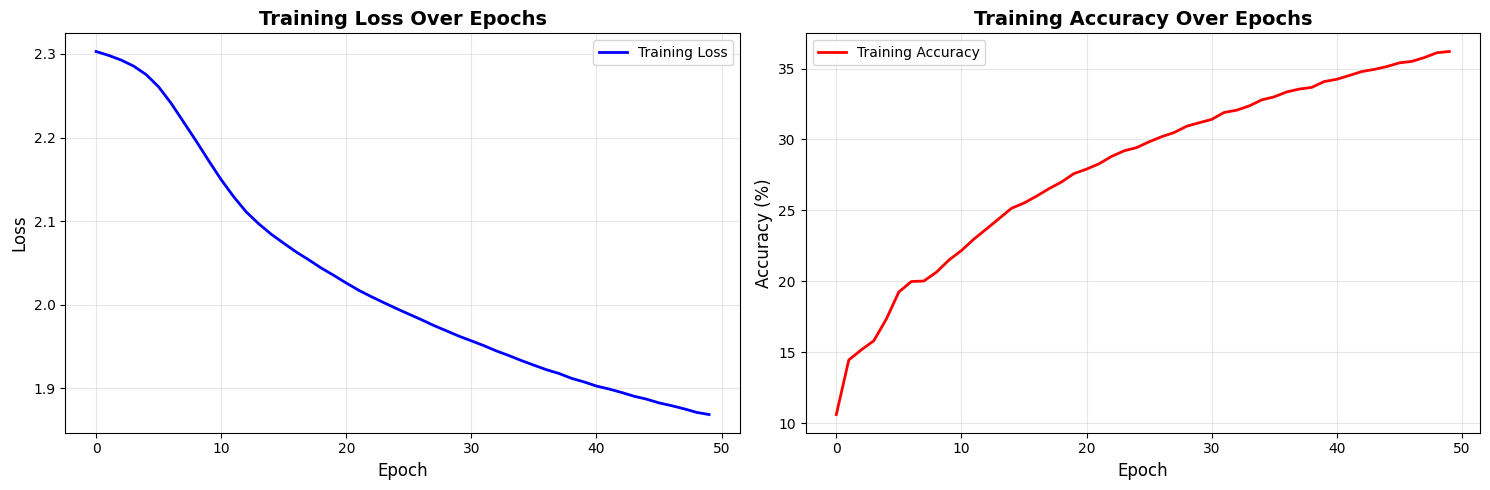


2. Confusion Matrix:


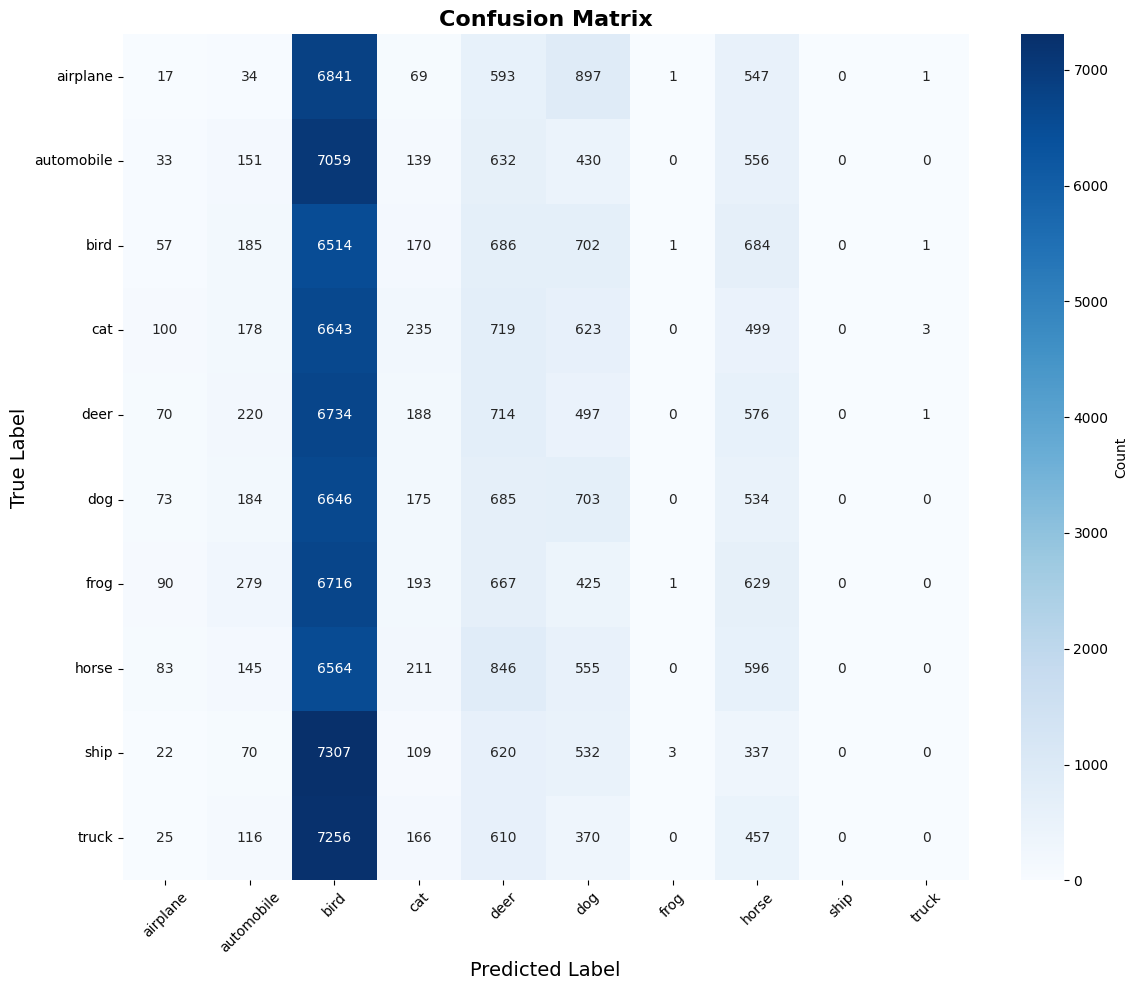


3. Per-Class Metrics:


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


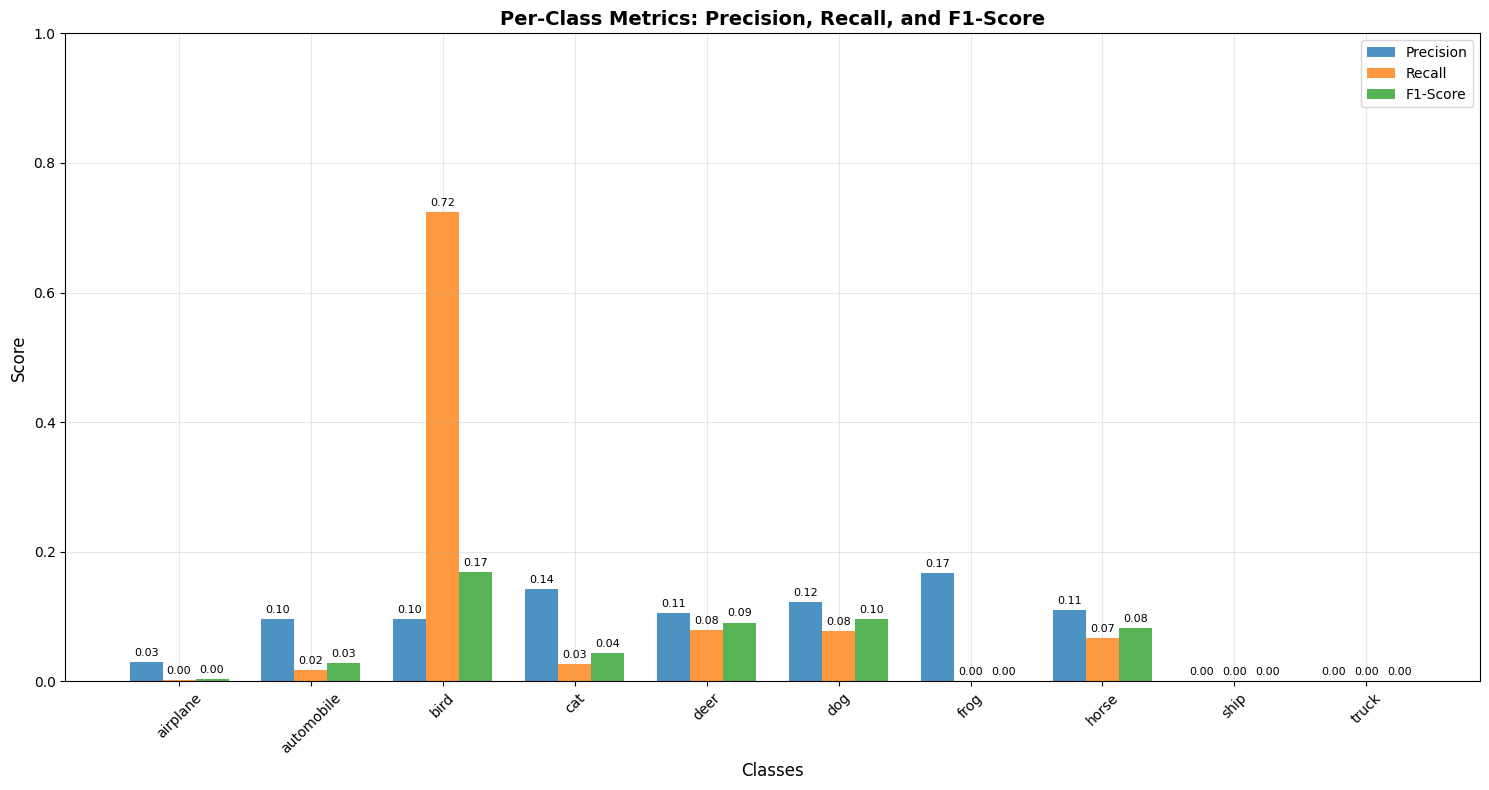


DETAILED CLASSIFICATION REPORT
              precision    recall  f1-score   support

    airplane     0.0298    0.0019    0.0036      9000
  automobile     0.0967    0.0168    0.0286      9000
        bird     0.0954    0.7238    0.1686      9000
         cat     0.1420    0.0261    0.0441      9000
        deer     0.1054    0.0793    0.0905      9000
         dog     0.1226    0.0781    0.0954      9000
        frog     0.1667    0.0001    0.0002      9000
       horse     0.1101    0.0662    0.0827      9000
        ship     0.0000    0.0000    0.0000      9000
       truck     0.0000    0.0000    0.0000      9000

    accuracy                         0.0992     90000
   macro avg     0.0869    0.0992    0.0514     90000
weighted avg     0.0869    0.0992    0.0514     90000



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
# Evaluating trained FNN model
predictions, true_labels, accuracy = comprehensive_evaluation(
    fnn_model, testloader, fnn_train_losses, fnn_train_accuracies, class_names
)

### Evaluation Convolutional Neural Network (CNN)

Evaluating model...
Test Accuracy: 64.65%

1. Training History:


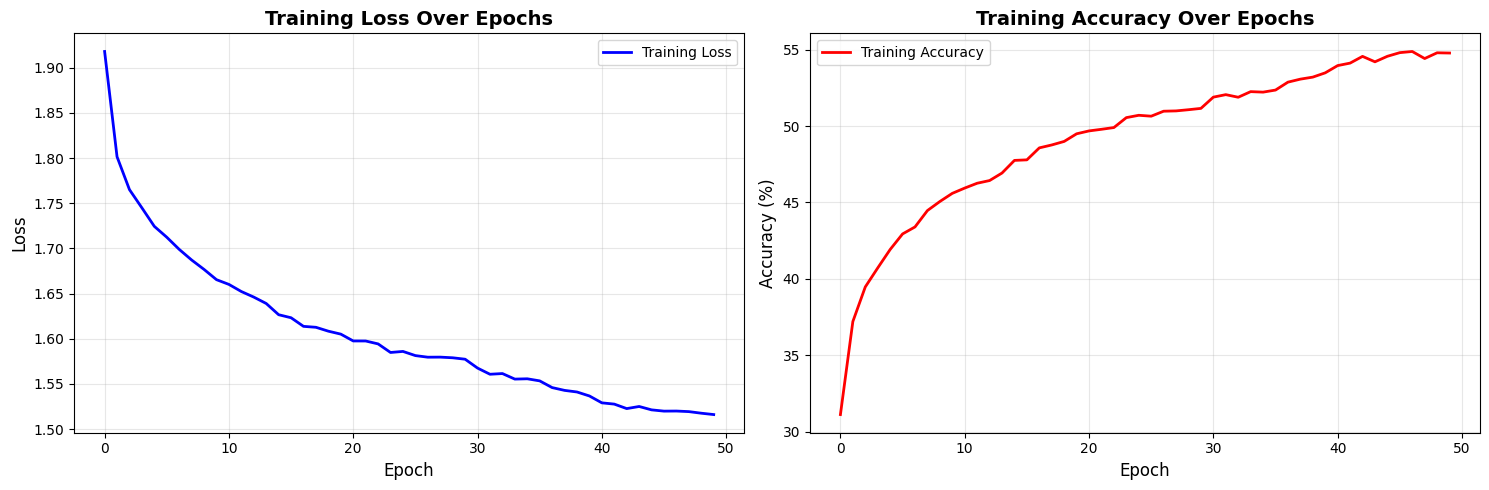


2. Confusion Matrix:


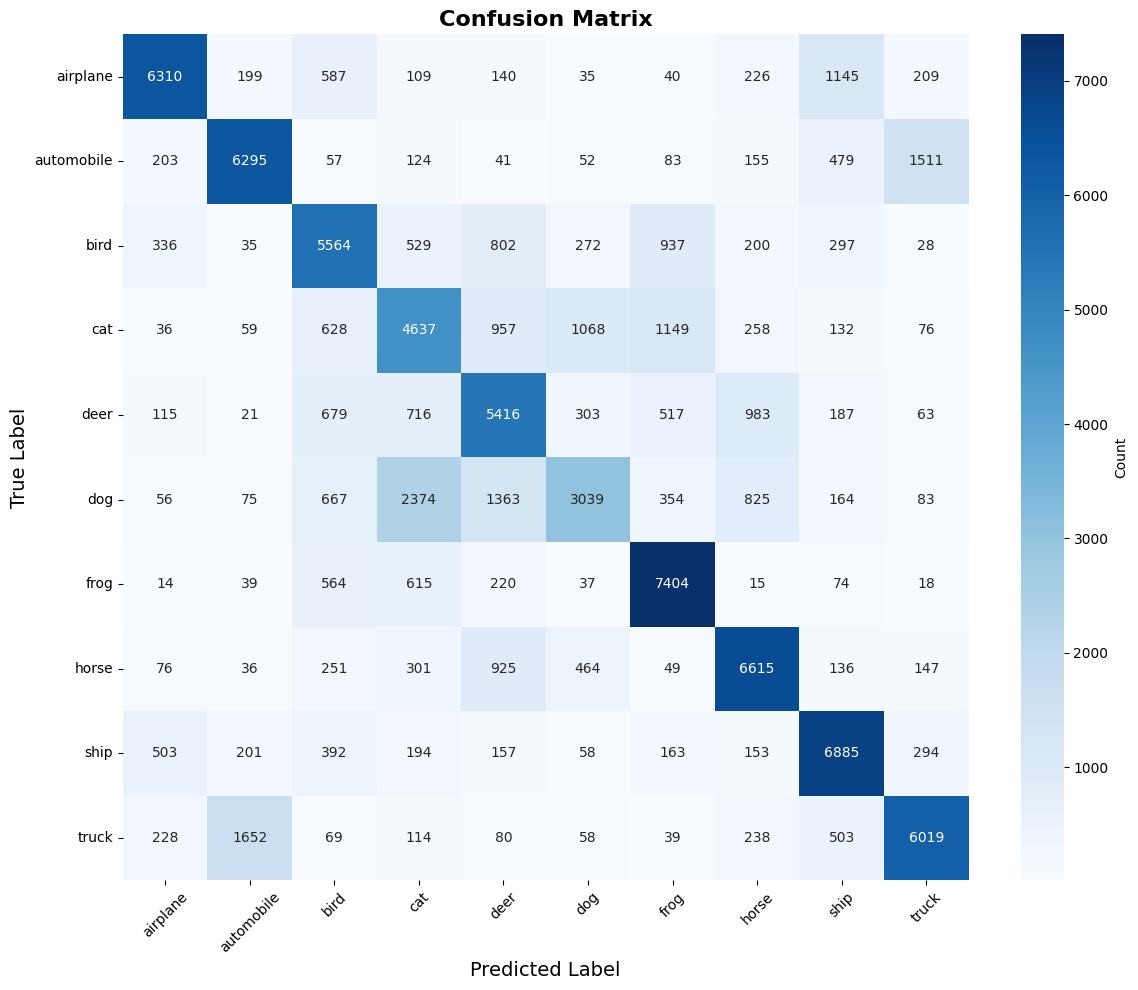


3. Per-Class Metrics:


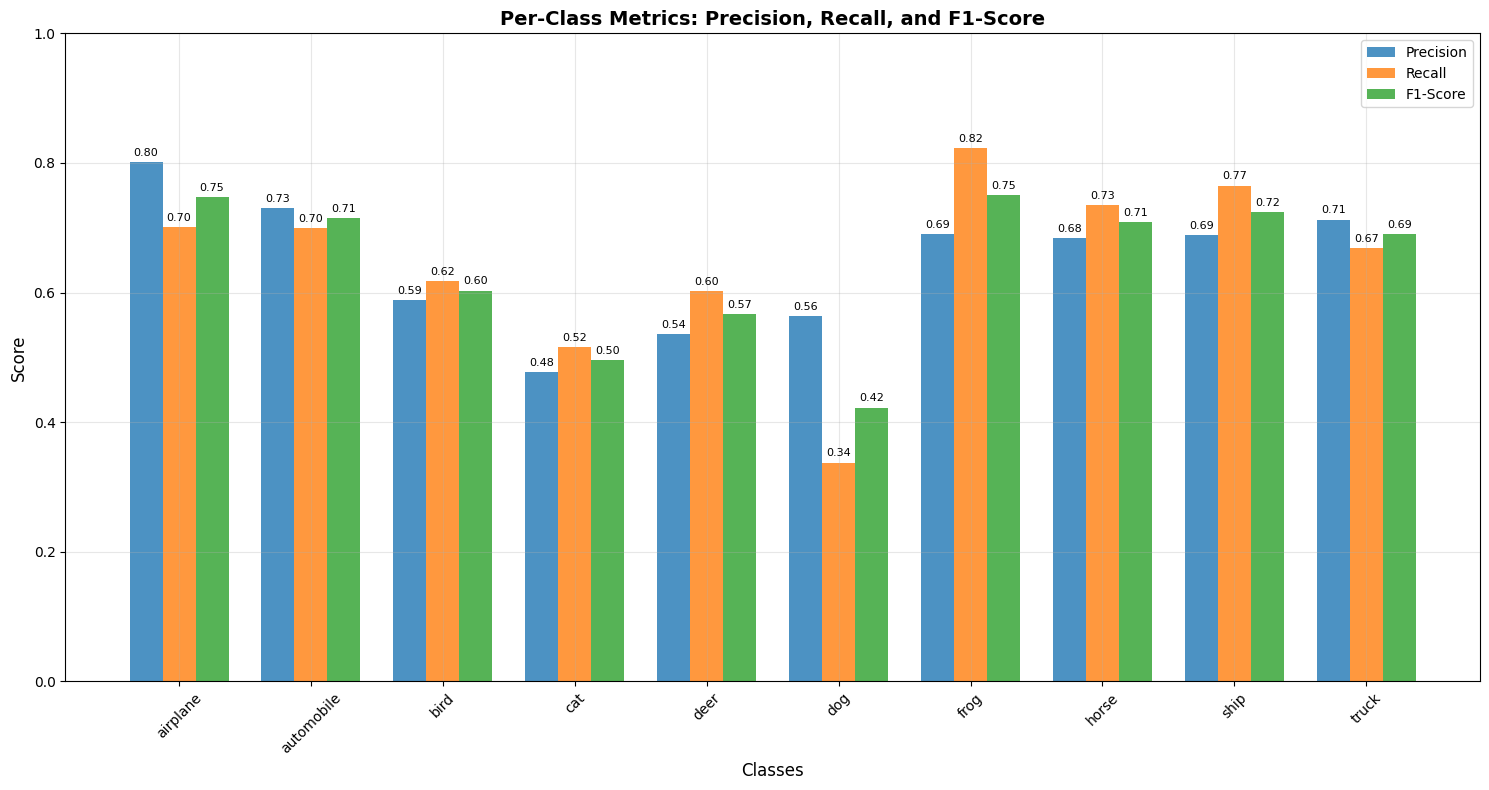


DETAILED CLASSIFICATION REPORT
              precision    recall  f1-score   support

    airplane     0.8011    0.7011    0.7478      9000
  automobile     0.7310    0.6994    0.7149      9000
        bird     0.5883    0.6182    0.6029      9000
         cat     0.4774    0.5152    0.4956      9000
        deer     0.5362    0.6018    0.5671      9000
         dog     0.5642    0.3377    0.4225      9000
        frog     0.6897    0.8227    0.7503      9000
       horse     0.6842    0.7350    0.7087      9000
        ship     0.6884    0.7650    0.7247      9000
       truck     0.7125    0.6688    0.6899      9000

    accuracy                         0.6465     90000
   macro avg     0.6473    0.6465    0.6424     90000
weighted avg     0.6473    0.6465    0.6424     90000



In [ ]:
# Evaluating trained CNN model
predictions, true_labels, accuracy = comprehensive_evaluation(
    cnn_model, testloader, cnn_train_losses, cnn_train_accuracies, class_names
)

## Accuracy and Loss Comparison among Training & Validation Datasets

In [ ]:
def plot_training_validation_comparison(history, save_path=None):
    """
    Plot training vs validation loss and accuracy comparison

    Args:
        history: Dictionary containing training history from train_model function
        save_path: Optional path to save the plot
    """

    train_losses = history['train_losses']
    train_accuracies = history['train_accuracies']
    val_losses = history['val_losses']
    val_accuracies = history['val_accuracies']

    epochs = range(1, len(train_losses) + 1)

    # Create figure with subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    # Loss Comparison Plot
    ax1.plot(epochs, train_losses, 'b-', linewidth=2, label='Training Loss', marker='o', markersize=4)
    ax1.plot(epochs, val_losses, 'r-', linewidth=2, label='Validation Loss', marker='s', markersize=4)

    ax1.set_title('Training vs Validation Loss', fontsize=16, fontweight='bold', pad=20)
    ax1.set_xlabel('Epoch', fontsize=14)
    ax1.set_ylabel('Loss', fontsize=14)
    ax1.legend(fontsize=12)
    ax1.grid(True, alpha=0.3)
    ax1.tick_params(axis='both', which='major', labelsize=12)

    # Add annotations for min values
    min_train_loss = min(train_losses)
    min_val_loss = min(val_losses)
    min_train_epoch = train_losses.index(min_train_loss) + 1
    min_val_epoch = val_losses.index(min_val_loss) + 1

    ax1.annotate(f'Min Train: {min_train_loss:.4f}',
                xy=(min_train_epoch, min_train_loss),
                xytext=(min_train_epoch + len(epochs)*0.1, min_train_loss + (max(train_losses) - min_train_loss)*0.1),
                arrowprops=dict(arrowstyle='->', color='blue', alpha=0.7),
                fontsize=10, color='blue')

    ax1.annotate(f'Min Val: {min_val_loss:.4f}',
                xy=(min_val_epoch, min_val_loss),
                xytext=(min_val_epoch + len(epochs)*0.1, min_val_loss + (max(val_losses) - min_val_loss)*0.1),
                arrowprops=dict(arrowstyle='->', color='red', alpha=0.7),
                fontsize=10, color='red')

    # Accuracy Comparison Plot
    ax2.plot(epochs, train_accuracies, 'b-', linewidth=2, label='Training Accuracy', marker='o', markersize=4)
    ax2.plot(epochs, val_accuracies, 'r-', linewidth=2, label='Validation Accuracy', marker='s', markersize=4)

    ax2.set_title('Training vs Validation Accuracy', fontsize=16, fontweight='bold', pad=20)
    ax2.set_xlabel('Epoch', fontsize=14)
    ax2.set_ylabel('Accuracy (%)', fontsize=14)
    ax2.legend(fontsize=12)
    ax2.grid(True, alpha=0.3)
    ax2.tick_params(axis='both', which='major', labelsize=12)

    # Add annotations for max values
    max_train_acc = max(train_accuracies)
    max_val_acc = max(val_accuracies)
    max_train_epoch = train_accuracies.index(max_train_acc) + 1
    max_val_epoch = val_accuracies.index(max_val_acc) + 1

    ax2.annotate(f'Max Train: {max_train_acc:.2f}%',
                xy=(max_train_epoch, max_train_acc),
                xytext=(max_train_epoch + len(epochs)*0.1, max_train_acc - (max_train_acc - min(train_accuracies))*0.1),
                arrowprops=dict(arrowstyle='->', color='blue', alpha=0.7),
                fontsize=10, color='blue')

    ax2.annotate(f'Max Val: {max_val_acc:.2f}%',
                xy=(max_val_epoch, max_val_acc),
                xytext=(max_val_epoch + len(epochs)*0.1, max_val_acc - (max_val_acc - min(val_accuracies))*0.1),
                arrowprops=dict(arrowstyle='->', color='red', alpha=0.7),
                fontsize=10, color='red')

    # Adjust layout
    plt.tight_layout()

    # Save plot if path provided
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Plot saved to: {save_path}")

    plt.show()

In [ ]:
def print_training_summary(history):
    """
    Print a summary of training results

    Args:
        history: Dictionary containing training history
    """

    train_losses = history['train_losses']
    train_accuracies = history['train_accuracies']
    val_losses = history['val_losses']
    val_accuracies = history['val_accuracies']

    print("\n" + "="*60)
    print("TRAINING SUMMARY")
    print("="*60)

    print(f"Total Epochs: {len(train_losses)}")
    print(f"\nFinal Results:")
    print(f"  Training Loss:      {train_losses[-1]:.4f}")
    print(f"  Validation Loss:    {val_losses[-1]:.4f}")
    print(f"  Training Accuracy:  {train_accuracies[-1]:.2f}%")
    print(f"  Validation Accuracy: {val_accuracies[-1]:.2f}%")

    print(f"\nBest Results:")
    print(f"  Best Training Loss:      {min(train_losses):.4f} (Epoch {train_losses.index(min(train_losses))+1})")
    print(f"  Best Validation Loss:    {min(val_losses):.4f} (Epoch {val_losses.index(min(val_losses))+1})")
    print(f"  Best Training Accuracy:  {max(train_accuracies):.2f}% (Epoch {train_accuracies.index(max(train_accuracies))+1})")
    print(f"  Best Validation Accuracy: {max(val_accuracies):.2f}% (Epoch {val_accuracies.index(max(val_accuracies))+1})")

    print("="*60)


In [ ]:
# Complete visualization function that combines everything
def complete_training_analysis(history, save_plots=False, plot_dir="./plots/"):
    """
    Complete analysis of training results with all visualizations

    Args:
        history: Dictionary containing training history from train_model function
        save_plots: Whether to save plots to files
        plot_dir: Directory to save plots
    """

    if save_plots and not os.path.exists(plot_dir):
        os.makedirs(plot_dir)

    # summary
    print_training_summary(history)

    # Main comparison plot
    print("Training vs Validation Comparison:")
    save_path1 = os.path.join(plot_dir, "train_val_comparison.png") if save_plots else None
    plot_training_validation_comparison(history, save_path1)


### Analysis of FNN Visualizations

In [ ]:
analyze_feedforward_architecture(fnn_model)

FEEDFORWARD NETWORK ANALYSIS

Model Summary:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                 [-1, 3072]               0
            Linear-2                 [-1, 1024]       3,146,752
              ReLU-3                 [-1, 1024]               0
            Linear-4                  [-1, 512]         524,800
              ReLU-5                  [-1, 512]               0
            Linear-6                  [-1, 256]         131,328
              ReLU-7                  [-1, 256]               0
            Linear-8                  [-1, 128]          32,896
              ReLU-9                  [-1, 128]               0
           Linear-10                   [-1, 10]           1,290
Total params: 3,837,066
Trainable params: 3,837,066
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass s


TRAINING SUMMARY
Total Epochs: 50

Final Results:
  Training Loss:      1.8688
  Validation Loss:    1.8807
  Training Accuracy:  36.20%
  Validation Accuracy: 35.60%

Best Results:
  Best Training Loss:      1.8688 (Epoch 50)
  Best Validation Loss:    1.8807 (Epoch 50)
  Best Training Accuracy:  36.20% (Epoch 50)
  Best Validation Accuracy: 35.60% (Epoch 50)
Training vs Validation Comparison:
Plot saved to: ./plots/train_val_comparison.png


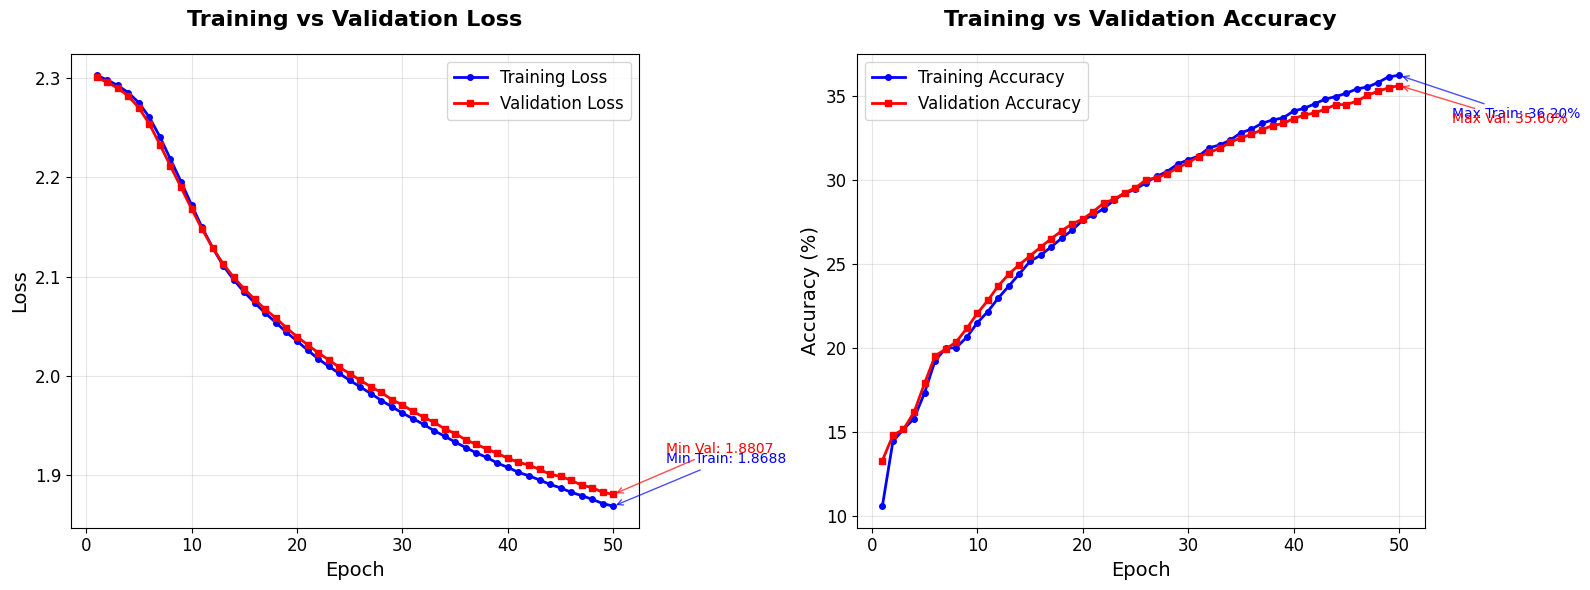

In [ ]:
# FNN Complete analysis with all visualizations
complete_training_analysis(fnn_history, save_plots=True)

### Analysis of CNN Visualizations

In [ ]:
analyze_cnn_architecture(cnn_model)


CNN ARCHITECTURE ANALYSIS

Model Summary:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
       BatchNorm2d-2           [-1, 32, 32, 32]              64
              ReLU-3           [-1, 32, 32, 32]               0
         MaxPool2d-4           [-1, 32, 16, 16]               0
            Conv2d-5           [-1, 64, 16, 16]          18,496
       BatchNorm2d-6           [-1, 64, 16, 16]             128
              ReLU-7           [-1, 64, 16, 16]               0
         MaxPool2d-8             [-1, 64, 8, 8]               0
            Linear-9                  [-1, 128]         524,416
             ReLU-10                  [-1, 128]               0
          Dropout-11                  [-1, 128]               0
           Linear-12                   [-1, 10]           1,290
Total params: 545,290
Trainable params: 545,290
Non-trainable


TRAINING SUMMARY
Total Epochs: 50

Final Results:
  Training Loss:      1.5160
  Validation Loss:    1.3323
  Training Accuracy:  54.77%
  Validation Accuracy: 64.59%

Best Results:
  Best Training Loss:      1.5160 (Epoch 50)
  Best Validation Loss:    1.3323 (Epoch 50)
  Best Training Accuracy:  54.88% (Epoch 47)
  Best Validation Accuracy: 64.61% (Epoch 44)
Training vs Validation Comparison:
Plot saved to: ./plots/train_val_comparison.png


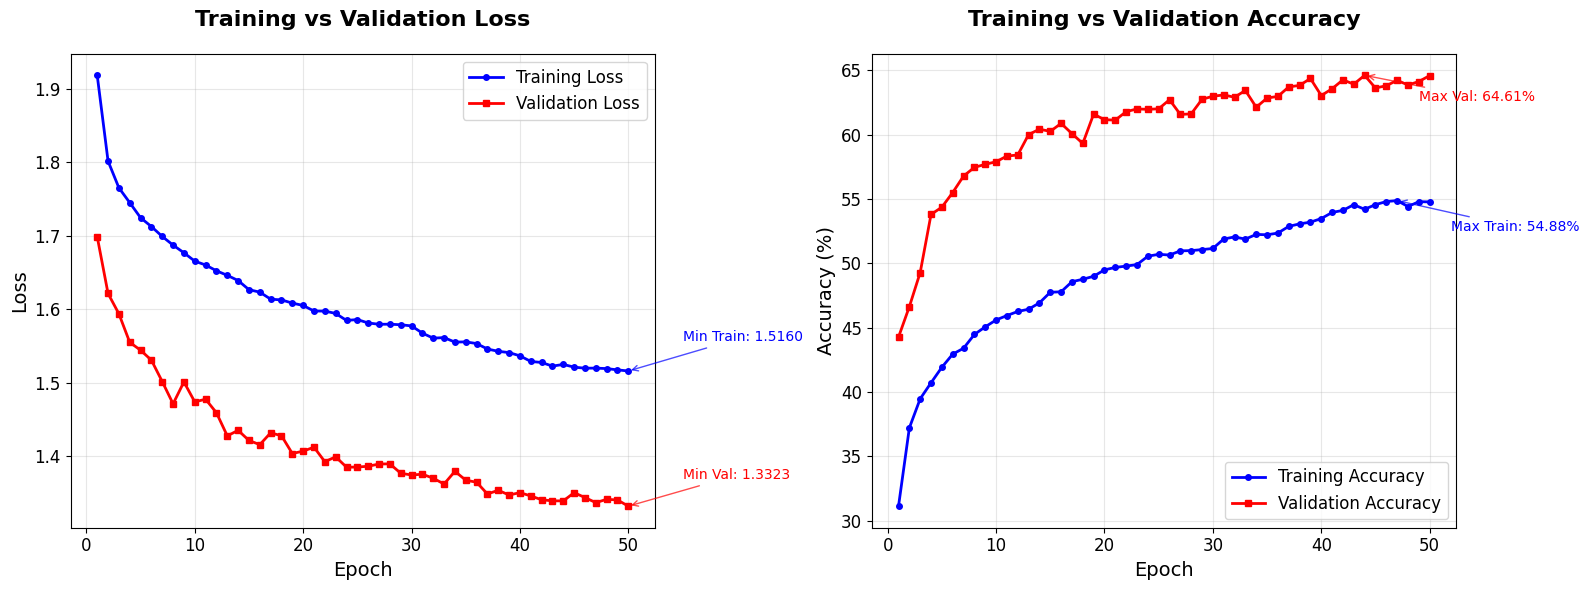

In [ ]:
# CNN Complete analysis with all visualizations
complete_training_analysis(cnn_history, save_plots=True)

## Save Trained and Validated Models


In [ ]:
# Saving the trained models
torch.save(fnn_model.state_dict(), f"/content/fnn_cinic10_v0.pth")
torch.save(cnn_model.state_dict(), f"/content/cnn_cinic10_v0.pth")

## Test the Model


In [ ]:
# test loading the model
fnn_model.load_state_dict(torch.load(f"/content/fnn_cinic10_v0.pth"))
cnn_model.load_state_dict(torch.load(f"/content/cnn_cinic10_v0.pth"))
print("Model(s) loaded successfully!")

Model(s) loaded successfully!


In [ ]:
def test_model(model, test_dataloader):
  """
  Test the model on a batch of images and show the predicted and actual labels
  """
  dataiter = iter(trainloader)
  images, labels = next(dataiter)
  outputs = model(images)
  _, predicted = torch.max(outputs, 1)
  print("Predicted labels: ", " ".join(f"{predicted[j]}" for j in range(batch_size)))
  print("Actual labels:    ", " ".join(f"{labels[j]}" for j in range(batch_size)))

### Testing FNN Trained Model

In [ ]:
test_model(fnn_model, testloader)


Predicted labels:  2 2 2 2 2 2 2 4 2 2 2 2 2 2 2 2 5 3 2 2 2 4 2 2 2 0 2 4 2 4 2 2 2 2 7 7 2 2 2 2 2 2 2 4 2 2 3 1 2 2 2 1 5 2 2 2 2 2 2 2 2 2 2 5 2 2 2 2 5 4 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 2 2 2 2 2 2 2 7 4 2 2 2 2 7 2 2 2 5 2 2 5 2 2 2 2 2 2 2 2 2 2 2
Actual labels:     8 6 5 5 5 3 1 7 0 9 0 8 3 1 6 5 4 4 9 4 5 5 2 6 1 1 5 9 5 7 6 5 1 4 3 0 9 0 4 4 0 4 4 1 1 3 1 4 5 4 6 2 8 6 3 1 6 8 8 7 6 9 7 5 2 0 1 2 2 2 3 5 1 6 1 3 0 3 4 9 6 7 8 0 6 3 1 9 1 1 5 6 8 3 2 3 6 8 4 6 2 4 2 6 1 7 8 1 6 6 0 7 5 8 2 8 3 7 2 8 0 2 9 5 9 8 3 1


### Testing CNN Trained Model

In [ ]:
test_model(cnn_model, testloader)

Predicted labels:  8 9 6 3 7 0 3 7 2 2 5 6 5 9 6 1 4 7 6 3 5 4 6 9 1 1 3 5 2 8 9 6 1 3 0 6 0 9 9 2 2 7 6 3 3 5 6 4 2 4 9 9 1 8 7 6 1 3 6 5 0 4 2 1 3 7 7 2 0 7 7 6 6 0 0 7 4 4 8 4 9 0 6 7 1 5 5 8 0 6 8 2 1 0 8 8 0 2 7 7 6 4 3 3 3 8 9 4 4 6 0 4 0 4 7 0 2 5 6 2 9 0 7 9 1 1 1 8
Actual labels:     7 9 6 5 7 0 3 7 6 2 5 6 3 1 2 9 4 4 6 3 5 4 6 9 1 9 2 5 2 1 9 2 1 3 0 5 0 1 9 2 2 7 6 3 3 5 4 4 5 4 9 9 1 8 7 6 7 3 5 3 0 4 6 1 5 7 5 1 0 4 7 6 6 0 0 5 4 4 8 5 9 0 6 7 1 5 5 1 0 5 8 2 1 0 8 8 0 0 7 7 3 4 3 6 3 8 9 4 4 6 0 4 0 4 7 0 5 5 6 5 9 9 4 8 8 1 1 8
